# **Wildfire Prediction Project**

In this project, we will compare the performance of a convolutional neural network and a vision transformer to classify images of wildfire-prone areas of Canada based on their wildfire risk. We will build a small convolutional neural network and vision transformer and tinker with the model hyperparameters to explore which option is better for classification, taking into account the smaller structure and computational efficiency of the vision transformer.

**Step One:**
Pull data from [Kaggle wildfire prediction dataset](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data)

In [ ]:
%pip install -q comet_ml
import comet_ml; comet_ml.init(log_graph=True)

In [ ]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="",
  project_name="wildfire",
  workspace=""
)

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.optim import Adam

from fastprogress.fastprogress import master_bar, progress_bar

# Data Collection

In [4]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oliverricken","key":"5e75e1057b8c33f78a63b5f7b317d92f"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 99% 1.43G/1.45G [00:12<00:00, 152MB/s]
100% 1.45G/1.45G [00:12<00:00, 127MB/s]


In [ ]:
!unzip wildfire-prediction-dataset.zip

In [9]:
train_path = "/content/train"
valid_path = "/content/valid"
test_path = "/content/test"

**Data Transformations:**

*   Resize: Resizes all images to 350x350.
*   RandomHorizontalFlip: Adds random flips for data augmentation.
*   ToTensor: Converts images to PyTorch tensors.
*   Normalize: Normalizes with ImageNet standard mean and standard deviation.

In [49]:
# ORIGINAL AUGMENTATION

"""
image_shape = (3,350,350)
N_CLASSES = 2
BATCH_SIZE = 256

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(train_path, transform=data_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_data = ImageFolder(valid_path, transform=data_transform)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

test_data = ImageFolder(test_path, transform=data_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
"""

In [52]:
# MODIFIED AUGMENTATION

image_shape = (3,350,350)
N_CLASSES = 2
BATCH_SIZE = 256

data_transform = transforms.Compose([
    transforms.Resize((350, 350)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.01, saturation=0.1),
    transforms.RandomResizedCrop(128, scale=(0.95, 1.05), ratio=(1.0, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(train_path, transform=data_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_data = ImageFolder(valid_path, transform=data_transform)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

test_data = ImageFolder(test_path, transform=data_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
# sanity checks

# check the shape of the images
image = train_data[0][0]
print("shape of our images is: ", image.shape)

# see how many observations we have
print("size of train dataset: ", len(train_data))

shape of our images is:  torch.Size([3, 128, 128])
size of train dataset:  30250


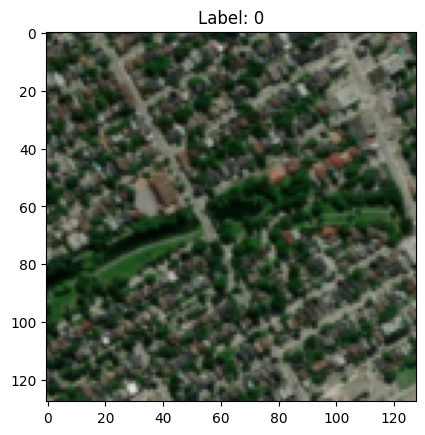

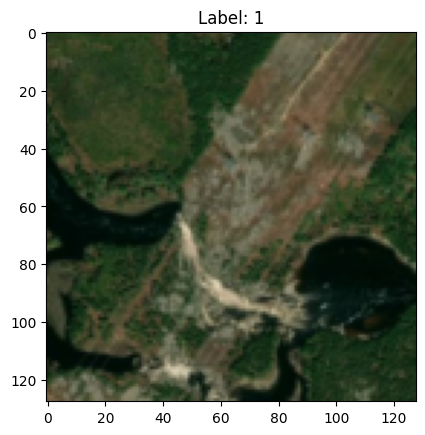

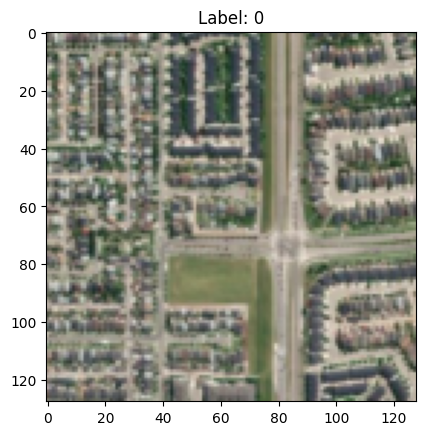

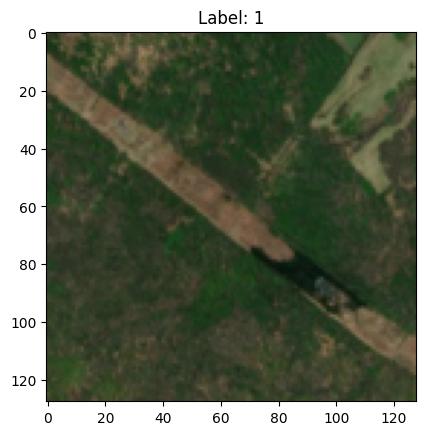

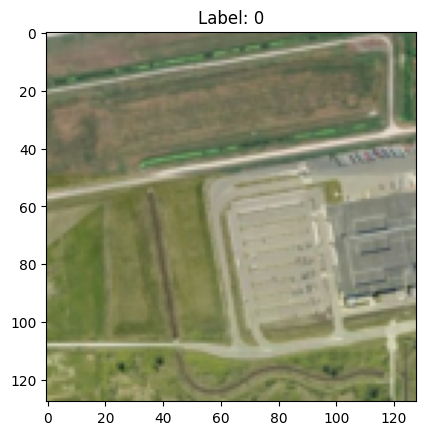

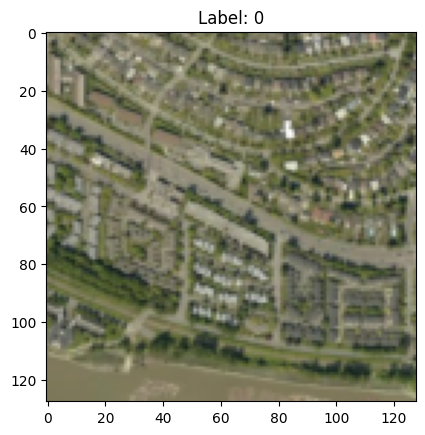

In [54]:
# Sanity check loop

for i, (images, labels) in enumerate(train_loader):
    if i >= 3:
        break

    # denormalize images for visualization
    images = images * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    for j in range(2):
        img = images[j].permute(1, 2, 0).numpy()
        label = labels[j].item()

        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.show()

# Model Support Code

In [40]:
# ensure we use the GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

Using 'cuda' device.


In [41]:
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

In [42]:
def run_model(model, optimizer=Adam,
              learning_rate=0.001):

    # Dataset is defined above in train_loader and valid_loader
    return gradient_descent(model, train_loader, valid_loader, optimizer, learning_rate)


def gradient_descent(model, train_loader, valid_loader, optimizer=Adam, learning_rate=0.001):

    # Do model creation here so that the model is recreated each time the cell is run
    model = model.to(device)

    t = 0
    # Create the optimizer, just like we have with the built-in optimizer
    opt = optimizer(model.parameters(), learning_rate)

    # A master bar for fancy output progress
    mb = master_bar(range(num_epochs))

    # Information for plots
    mb.names = ["Train Loss", "Valid Loss"]
    train_losses = []
    valid_losses = []

    for epoch in mb:

        #
        # Training
        #
        model.train()

        train_N = len(train_loader.dataset)
        num_train_batches = len(train_loader)
        train_dataiterator = iter(train_loader)

        train_loss_mean = 0

        for batch in progress_bar(range(num_train_batches), parent=mb):

            # Grab the batch of data and send it to the correct device
            try:
              train_X, train_Y = next(train_dataiterator)
            except OSError:
              print("OS Error!")
              continue
            train_X, train_Y = train_X.to(device), train_Y.to(device)

            # Compute the output
            train_output = model(train_X)

            # Compute loss
            train_loss = criterion(train_output, train_Y)

            num_in_batch = len(train_X)
            tloss = train_loss.item() * num_in_batch / train_N
            train_loss_mean += tloss
            train_losses.append(train_loss.item())

            # Compute gradient
            model.zero_grad()
            train_loss.backward()

            # Take a step of gradient descent
            t += 1
            with torch.no_grad():
                opt.step()

        #
        # Validation
        #
        model.eval()

        valid_N = len(valid_loader.dataset)
        num_valid_batches = len(valid_loader)

        valid_loss_mean = 0
        valid_correct = 0

        with torch.no_grad():

            # valid_loader is probably just one large batch, so not using progress bar
            for valid_X, valid_Y in valid_loader:

                valid_X, valid_Y = valid_X.to(device), valid_Y.to(device)

                valid_output = model(valid_X)

                valid_loss = criterion(valid_output, valid_Y)

                num_in_batch = len(valid_X)
                vloss = valid_loss.item() * num_in_batch / valid_N
                valid_loss_mean += vloss
                valid_losses.append(valid_loss.item())

                # Convert network output into predictions (one-hot -> number)
                predictions = valid_output.argmax(1)

                # Sum up total number that were correct
                valid_correct += (predictions == valid_Y).type(torch.float).sum().item()

        valid_accuracy = 100 * (valid_correct / valid_N)

        # Report information
        tloss = f"Train Loss = {train_loss_mean:.4f}"
        vloss = f"Valid Loss = {valid_loss_mean:.4f}"
        vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
        mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

        # Update plot data
        max_loss = max(max(train_losses), max(valid_losses))
        min_loss = min(min(train_losses), min(valid_losses))

        x_margin = 0.2
        x_bounds = [0 - x_margin, num_epochs + x_margin]

        y_margin = 0.1
        y_bounds = [min_loss - y_margin, max_loss + y_margin]

        valid_Xaxis = torch.linspace(0, epoch + 1, len(train_losses))
        valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
        graph_data = [[valid_Xaxis, train_losses], [valid_xaxis, valid_losses]]

        mb.update_graph(graph_data, x_bounds, y_bounds)

    print(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

# Model Creation

In [43]:
model = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=2, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(8, 16, kernel_size=2, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(p=0.6),
            nn.Flatten(),
            # 256 feature maps of size 16x16 after pooling is 256*16*16 = 65536
            nn.Linear(16384, 300),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(300, 2)
        )

In [44]:
model = model.to(device)
model_summary = summary(model, (3, 128, 128))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             104
              ReLU-2          [-1, 8, 128, 128]               0
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             528
              ReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
           Dropout-7           [-1, 16, 32, 32]               0
           Flatten-8                [-1, 16384]               0
            Linear-9                  [-1, 300]       4,915,500
             ReLU-10                  [-1, 300]               0
          Dropout-11                  [-1, 300]               0
           Linear-12                    [-1, 2]             602
Total params: 4,916,734
Trainable params: 4,916,734
Non-trainable params: 0
---------------------------

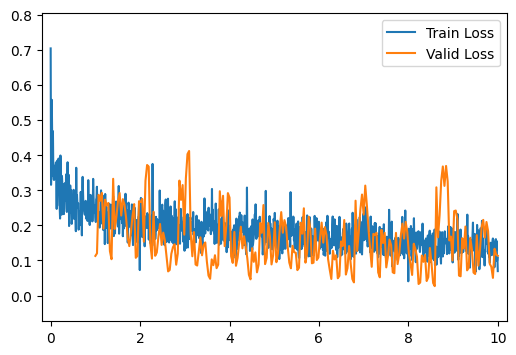

[10/10] Train Loss = 0.1440; Valid Loss = 0.1251; Valid Accuracy = 95.3%


In [45]:
# Report multiple hyperparameters using a dictionary:
hyper_params = {
   "learning_rate": 0.001,
   "batch_size": 256,
}
experiment.log_parameters(hyper_params)
experiment.log_text(str(model_summary))

# Initialize and train your model
run_model(model)

# Seamlessly log your Pytorch model
log_model(experiment, model=model, model_name="Augment_2_Layer_CNN_128")

In [46]:
torch.save(model.state_dict(), "/content/2_Layer_CNN_128_Aug.pt")

In [ ]:
model.load_state_dict(torch.load("/content/2_Layer_CNN_128_Aug.pt"))
model.to(device)

In [48]:
model.eval()

test_loss_mean = 0
test_correct = 0

with torch.no_grad():
    for test_X, test_Y in test_loader:
        try:
            test_X, test_Y = test_X.to(device), test_Y.to(device)
            test_output = model(test_X)
            test_loss = criterion(test_output, test_Y)  # Make sure you have ‘criterion’ defined

            num_in_batch = len(test_X)
            tloss = test_loss.item() * num_in_batch / len(test_loader.dataset)
            test_loss_mean += tloss

            predictions = test_output.argmax(1)
            test_correct += (predictions == test_Y).type(torch.float).sum().item()

        except OSError:
            print("OS Error!")
            continue

test_accuracy = 100 * (test_correct / len(test_loader.dataset))

print(f"Test Loss = {test_loss_mean:.4f}")
print(f"Test Accuracy = {(test_accuracy):>0.1f}%")

Test Loss = 0.1104
Test Accuracy = 96.3%
